# 2 - Supervised ML

Based on assignment 2 of [Applied Machine Learning in Python | Coursera](https://www.coursera.org/learn/python-machine-learning)

Goal: Explore the relationship between model complexity and generalization performance

Data (classification): [UCI Mushroom Data Set](http://archive.ics.uci.edu/ml/datasets/Mushroom?ref=datanews.io)

## Part 1 - Regression

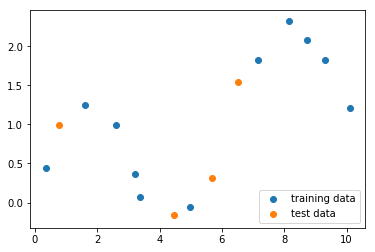

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

np.random.seed(0)
n = 15
x = np.linspace(0,10,n) + np.random.randn(n)/5
y = np.sin(x)+x/6 + np.random.randn(n)/10

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=0)

plt.scatter(X_train, y_train, label='training data')
plt.scatter(X_test, y_test, label='test data')
plt.legend(loc=4);

In [2]:
X_train, X_test, y_train, y_test = X_train.reshape(-1,1), X_test.reshape(-1,1), y_train.reshape(-1,1), y_test.reshape(-1,1)

#### Polynomial Linear regression

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics.regression import r2_score


X_interval_test = np.linspace(1,10,100).reshape(-1,1)
degrees = (1, 3, 6, 9)
pred = np.empty([len(degrees), len(X_interval_test)])

for idx, degree in enumerate(degrees):

    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train)
    X_interval_test_poly = poly.transform(X_interval_test)

    reg = None
    reg = LinearRegression().fit(X_train_poly, y_train)

    prediction = reg.predict(X_interval_test_poly)

    pred[idx,:] = prediction.reshape(-1)       

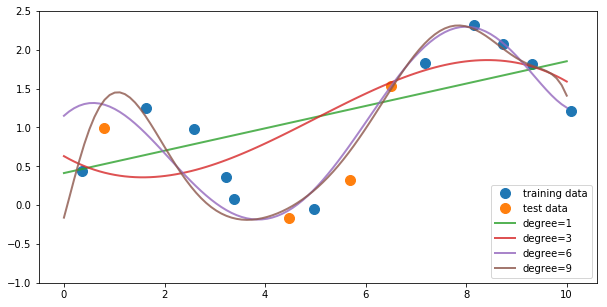

In [4]:
plt.figure(figsize=(10,5))
plt.plot(X_train, y_train, 'o', label='training data', markersize=10)
plt.plot(X_test, y_test, 'o', label='test data', markersize=10)
for i,degree in enumerate([1,3,6,9]):
    plt.plot(np.linspace(0,10,100), pred[i], alpha=0.8, lw=2, label='degree={}'.format(degree))
plt.ylim(-1,2.5)
plt.legend(loc=4);

### r2 score vs degree of polynomial features

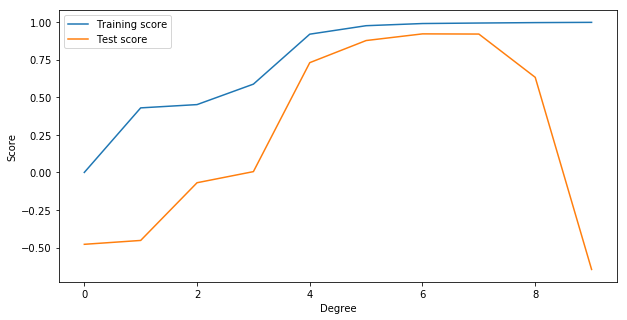

In [5]:
r2_train, r2_test = np.empty(10), np.empty(10)

for degree in range(10):

    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    reg = None
    reg = LinearRegression().fit(X_train_poly, y_train)

    r2_train[degree] = reg.score(X_train_poly, y_train)
    r2_test[degree] = reg.score(X_test_poly, y_test)   
    
plt.figure(figsize=(10,5))
plt.plot(r2_train, label='Training score')
plt.plot(r2_test, label='Test score')
plt.xlabel('Degree')
plt.ylabel('Score')
plt.legend();

In [6]:
underfitting = []
overfitting = []
good_generalization = []

r2_max = r2_test.max()
degree_max = r2_test.argmax()


for d in range(10):
    r2 = r2_test[d]

    if d < degree_max and r2 < r2_max*0.9:
        underfitting.append(d)

    elif d > degree_max and r2 < r2_max*0.9: 
        overfitting.append(d)
    else:
        good_generalization.append(d)

print('Underfitting degrees: \t\t', underfitting)
print('Good generalization degrees: \t', good_generalization)
print('Uverfitting degrees: \t\t', overfitting)



Underfitting degrees: 		 [0, 1, 2, 3, 4]
Good generalization degrees: 	 [5, 6, 7]
Uverfitting degrees: 		 [8, 9]


#### Lasso Regularized linear model

In [7]:
from sklearn.linear_model import Lasso

poly = PolynomialFeatures(degree=12)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)

lin_reg = LinearRegression().fit(X_train_poly, y_train)
lasso_reg = Lasso(alpha=0.01, max_iter=10000).fit(X_train_poly, y_train)

print("non-regulated linear regression acc: \t{:.3f}".format(lin_reg.score(X_test_poly, y_test)))
print("Lasso linear regression acc: \t\t{:.3f}".format(lasso_reg.score(X_test_poly, y_test)))

non-regulated linear regression acc: 	-4.312
Lasso linear regression acc: 		0.841


/home/angel/anaconda3/envs/gpu/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


## Part 2 - Classification

The  [UCI Mushroom Data Set](http://archive.ics.uci.edu/ml/datasets/Mushroom?ref=datanews.io) will be used to train a model to predict whether or not a mushroom is poisonous.

In [8]:
mush_df = pd.read_csv('data/mushrooms.csv')
mush_df2 = pd.get_dummies(mush_df)

X_mush = mush_df2.iloc[:,2:]
y_mush = mush_df2.iloc[:,1]

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_mush, y_mush, random_state=0)

####  Feature importances

In [9]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=0).fit(X_train2, y_train2)
imp = pd.Series(clf.feature_importances_, index=X_train2.columns)

print("Top features: ", list(imp.nlargest(n=5).index))

Top features:  ['odor_n', 'stalk-root_c', 'stalk-root_r', 'spore-print-color_r', 'odor_l']


####  Validation curve

In [10]:
from sklearn.svm import SVC
from sklearn.model_selection import validation_curve

param_range = np.logspace(-4,1,6)

train_scores, test_scores = validation_curve(SVC(random_state=0), 
                                             X_train2, y_train2,
                                            param_name='gamma',
                                            param_range=param_range, cv=3)

r2_train = np.mean(train_scores, axis=1)
r2_test = np.mean(test_scores, axis=1)

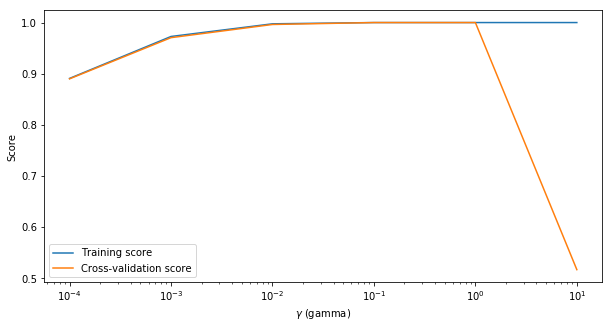

In [11]:
plt.figure(figsize=(10,5))
gamma = np.logspace(-4,1,6)
plt.xscale('log')
plt.xlabel('$\gamma$ (gamma)')
plt.ylabel('Score')
plt.semilogx(gamma, r2_train, label='Training score')
plt.semilogx(gamma, r2_test, label='Cross-validation score')
plt.legend(loc='best');

In [12]:
underfitting = []
overfitting = []
good_generalization = []

r2_tr_max = r2_train.max()
r2_cv_max = r2_test.max()


for idx, gamma in enumerate(np.logspace(-4,1,6)):
    r2_tr = r2_train[idx]
    r2_cv = r2_test[idx]

    if r2_tr < r2_tr_max*0.95 and r2_cv < r2_cv_max*0.95:
        underfitting.append(gamma)

    elif r2_cv < r2_cv_max: 
        overfitting.append(gamma)

    else:
        good_generalization.append(gamma)        
    
print('Underfitting degrees: \t\t', underfitting)
print('Good generalization degrees: \t', good_generalization)
print('Uverfitting degrees: \t\t', overfitting)

Underfitting degrees: 		 [0.0001]
Good generalization degrees: 	 [0.10000000000000001, 1.0]
Uverfitting degrees: 		 [0.001, 0.01, 10.0]
